In [1]:
import pandas as pd
import numpy as np
import warnings 
import time
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.metrics import davies_bouldin_score
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from yellowbrick.style import set_palette
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
warnings.filterwarnings('ignore')

In [4]:
data =  pd.read_csv('data.csv',  engine = 'python',  \
                    on_bad_lines = 'skip', index_col=[0])

## 2.1 calcul de RFM

In [6]:
last_buy = data['order_purchase_timestamp'].max()
print(last_buy)

2018-09-03 09:06:57


In [7]:
data['recence'] = (pd.to_datetime(last_buy) - \
    pd.to_datetime(data['order_purchase_timestamp'])).dt.days + 1
data['recence'] = data['recence'].astype(float)
data['review_score'] = data['review_score'].astype(float)

In [8]:
# Calcul de la fréquence pour chaque client
freq = data.groupby('customer_unique_id')\
    ['order_purchase_timestamp'].count().reset_index()
freq.columns = ['customer_unique_id', 'frequence']
data = pd.merge(data, freq, on='customer_unique_id')
data['frequence'] = data['frequence'].astype(float)

In [9]:
# Calcul du montant total dépensé pour chaque client
montant = data.groupby('customer_unique_id')['price']\
    .sum().reset_index()
montant.columns = ['customer_unique_id', 'montant_total']
data = pd.merge(data, montant, on='customer_unique_id')

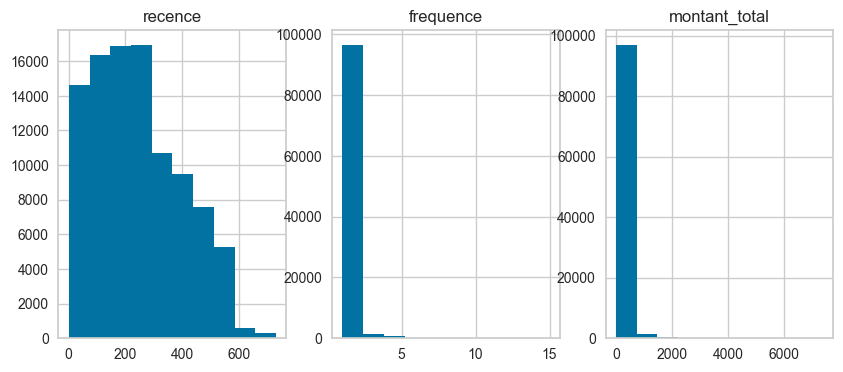

In [10]:
# affichage distribution
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].hist(data["recence"])
axs[0].set_title("recence")
axs[1].hist(data["frequence"])
axs[1].set_title("frequence")
axs[2].hist(data["montant_total"])
axs[2].set_title("montant_total")
plt.show()

In [11]:
# Normalisation 
data.loc[:, "frequence_norm"] = \
    np.log(data.loc[:, "frequence"])
data.loc[:, "recence_norm"], fitted_lambda = \
    stats.boxcox(data.loc[:, "recence"])
data.loc[:, "montant_norm"], fitted_lambda = \
    stats.boxcox(data.loc[:, "montant_total"])
data.loc[:, "review_norm"], fitted_lambda = \
    stats.boxcox(data.loc[:, "review_score"])

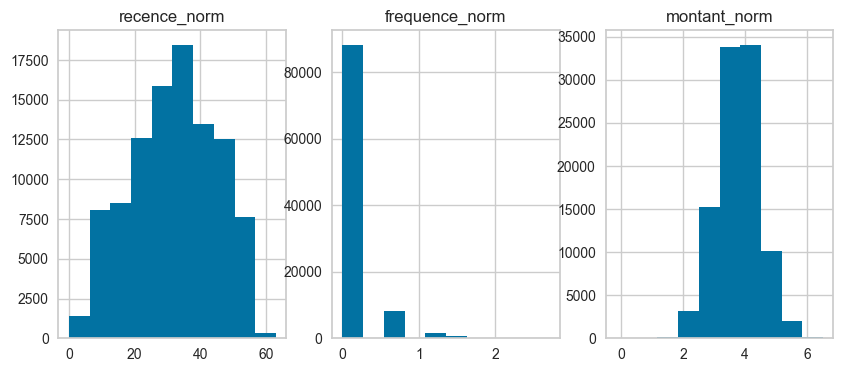

In [12]:
# affichage distribution
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].hist(data["recence_norm"])
axs[0].set_title("recence_norm")
axs[1].hist(data["frequence_norm"])
axs[1].set_title("frequence_norm")
axs[2].hist(data["montant_norm"])
axs[2].set_title("montant_norm")
plt.show()

In [13]:
data.to_csv("data_rfm.csv")

In [14]:
#Préparartion des données pour le clustering 
data_rfm = data.loc[:, ['recence', 'frequence', \
                    'montant_total']].copy()
data_rfm_norm = data.loc[:, ['recence_norm', 'frequence_norm', \
                    'montant_norm']].copy()

In [15]:
colonne_rfm = data_rfm.columns

scaler = StandardScaler()
X = scaler.fit_transform(data_rfm)
X_norm = scaler.fit_transform(data_rfm_norm)

## 2.2 Clustering par K_means

### 2.2.1 Clustering avec RFM

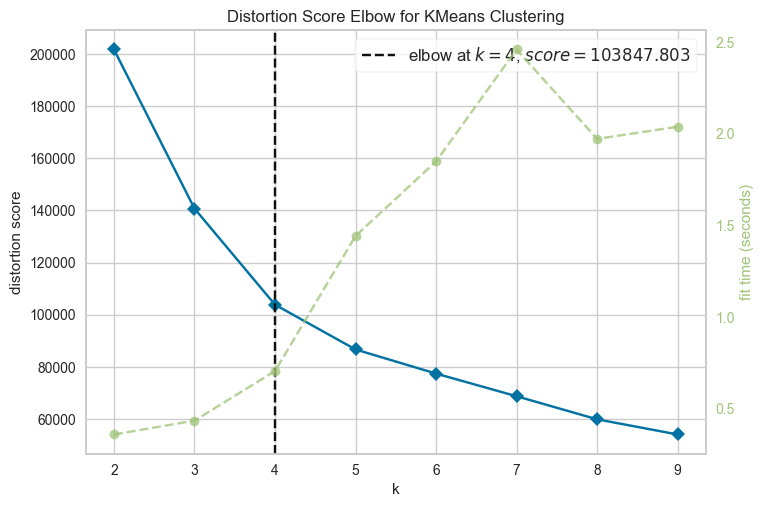

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
# Recherche le nombre de cluster optimal
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_norm)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [17]:
# Sélection de nombre de cluster à 4.  Instantiation Kmeans
model4 = KMeans(n_clusters=4)
clusters = model4.fit_predict(X_norm)
data_rfm['Cluster'] = clusters

In [18]:
#Intérprétation des clusters
result = data_rfm.groupby('Cluster').agg({
    'recence': 'mean',
    'frequence': 'mean',
    'montant_total': 'mean'
}).round(2)

result['count'] = data_rfm.groupby('Cluster').size()
result.head()

,recence,frequence,montant_total,count
Cluster,,,,
0,318.78,1.00,38.60,28614
1,86.22,1.00,109.73,29601
2,256.65,2.37,236.06,10614
3,326.43,1.00,230.01,29952


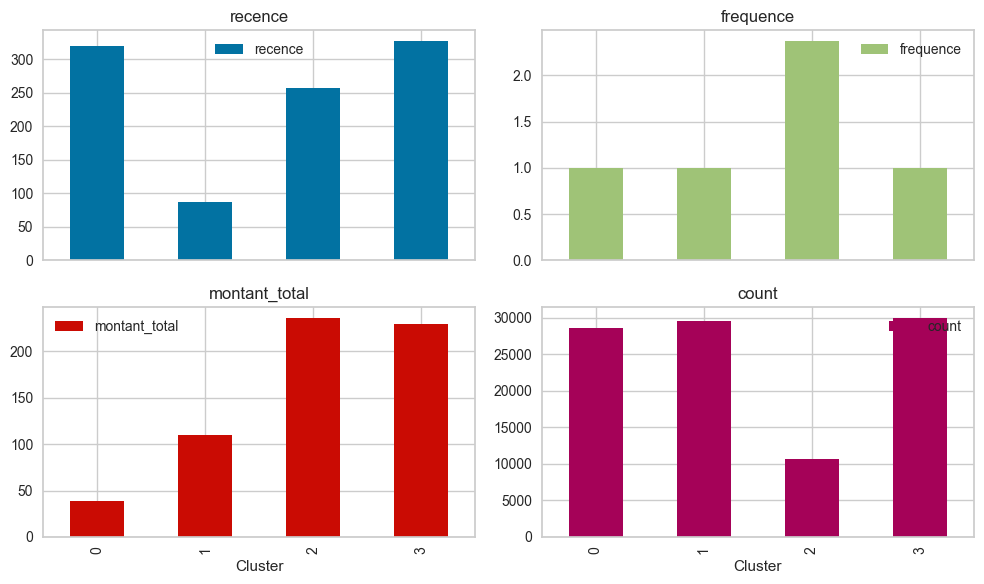

In [19]:
# Plot histograms for each column
result.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(10, 6))
plt.tight_layout()
plt.show()

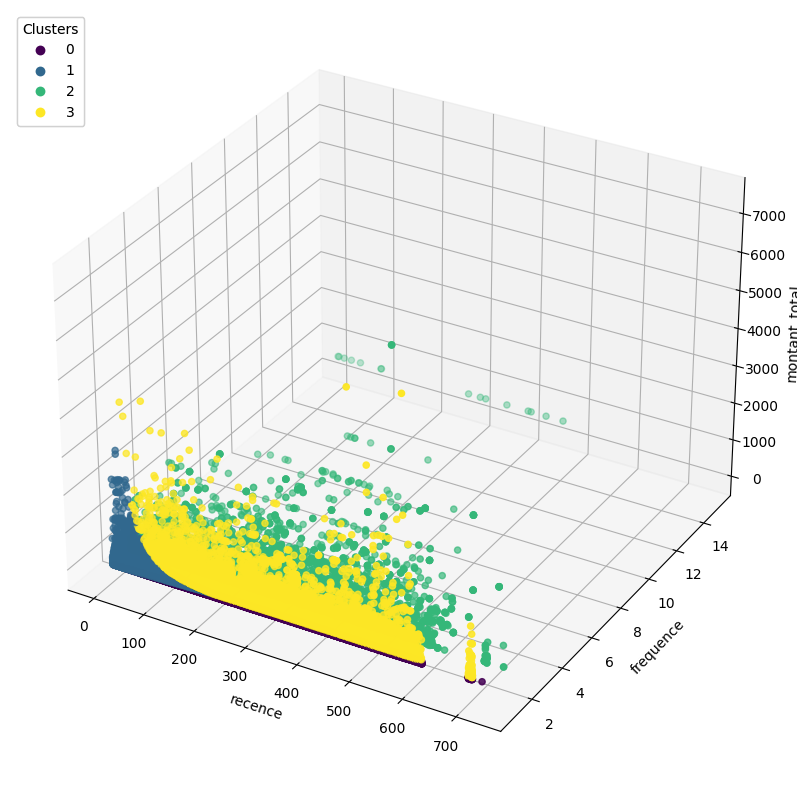

In [20]:
# visualisation en 3D des clusters
plt.rcdefaults()
x, y, z = colonne_rfm
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
sc = ax.scatter(data_rfm[x], data_rfm[y], data_rfm[z], c=data_rfm["Cluster"])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
# Create a legend with the labels for the different values of "label"
legend = ax.legend(*sc.legend_elements(), title="Clusters", loc="upper left")
ax.add_artist(legend)
plt.show()

In [21]:
# Du point de vue métiers, Il est plus pertinent de grouper cluster 0 et 3, 
model3 = KMeans(n_clusters=3)
clusters = model3.fit_predict(X_norm)
data_rfm['Cluster'] = clusters

result = data_rfm.groupby('Cluster').agg({
    'recence': 'mean',
    'frequence': 'mean',
    'montant_total': 'mean'
}).round(2)

result['count'] = data_rfm.groupby('Cluster').size()

In [22]:
result = data_rfm.groupby('Cluster').agg({
    'recence': 'mean',
    'frequence': 'mean',
    'montant_total': 'mean'
}).round(2)

result['count'] = data_rfm.groupby('Cluster').size()

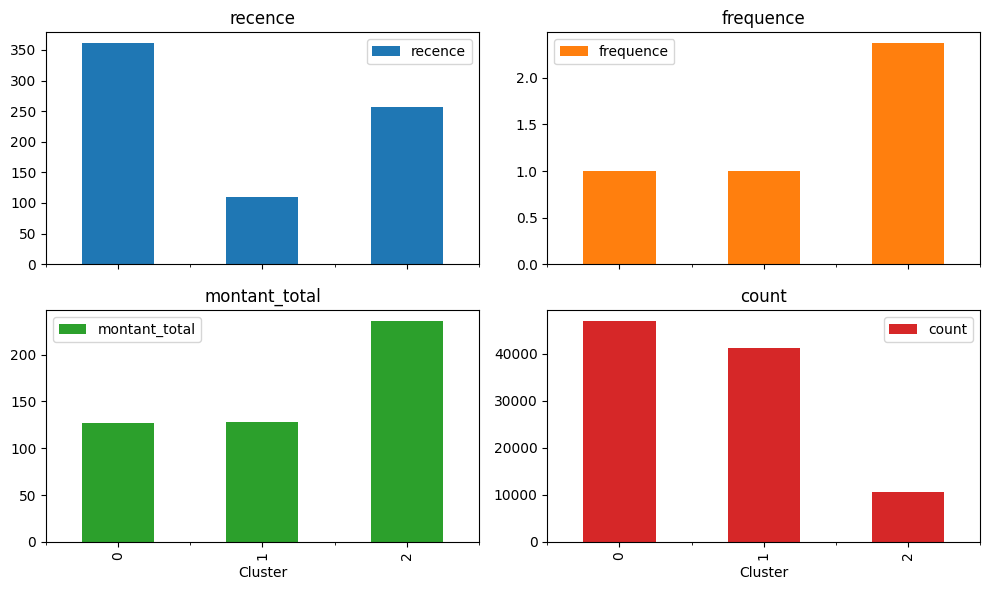

In [23]:
# Plot histograms for each column
result.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(10, 6))
plt.tight_layout()
plt.show()

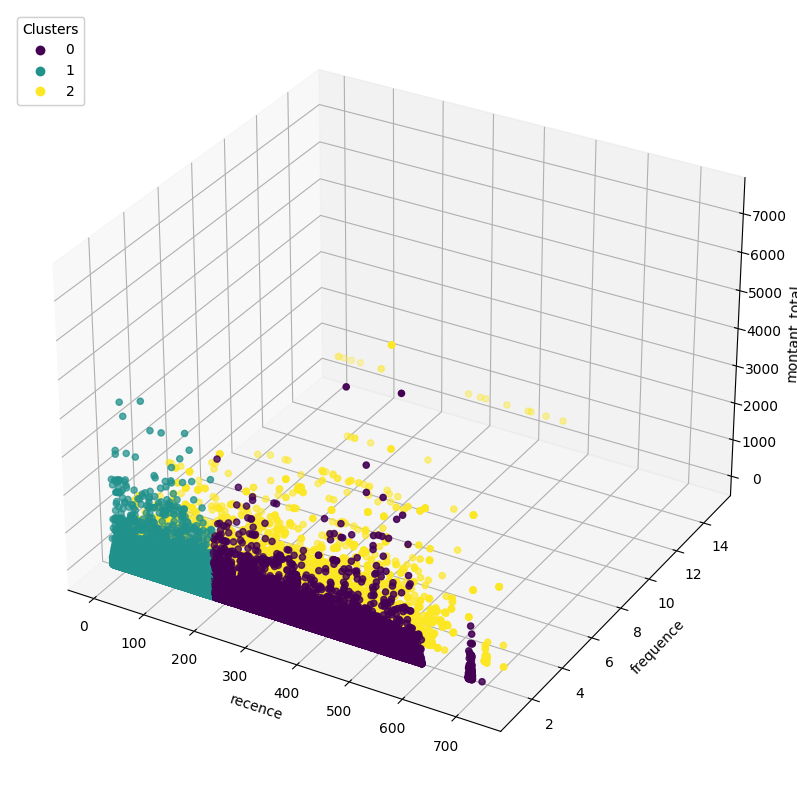

In [24]:
# visualisation en 3D des clusters
plt.rcdefaults()
x, y, z = colonne_rfm
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
sc = ax.scatter(data_rfm[x], data_rfm[y], data_rfm[z], c=data_rfm["Cluster"])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
# Create a legend with the labels for the different values of "label"
legend = ax.legend(*sc.legend_elements(), title="Clusters", loc="upper left")
ax.add_artist(legend)
plt.show()

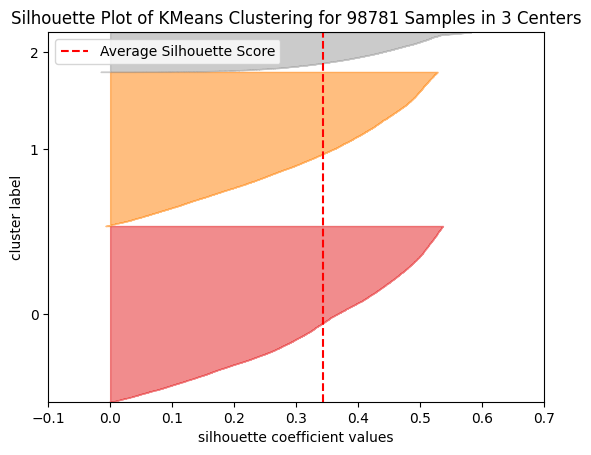

temps d'exec visu silouette =  244.65096020698547


In [25]:
start_time = time.time()
visualizer = SilhouetteVisualizer(model3)

visualizer.fit(X_norm)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data
end_time = time.time()
execution_time = end_time - start_time
print("temps d'exec visu silouette = ",execution_time )

In [ ]:
davies_bouldin = []
silhouette_scores = []

for k in range(2, 10):
    model = KMeans(n_clusters=k)
    labels = model.fit_predict(X_norm)
    davies_bouldin.append(davies_bouldin_score(X_norm, labels))
    silhouette_scores.append(silhouette_score(X_norm, labels))
    
plt.plot(davies_bouldin)
plt.title("Davies Bouldin score")
plt.show()

plt.plot(range(2, 10), silhouette_scores)
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score de silhouette')
plt.title("silhouette_score ")
plt.show()

### 2.2.2 Clustering avec RFM + review_score 

In [ ]:
data_rfm = data.loc[:, ['recence', 'frequence', \
        'montant_total', 'review_score']].copy()
data_rfm_norm = data.loc[:, ['recence_norm', \
        'frequence_norm', 'montant_norm', 'review_norm']].copy()

In [ ]:
colonne_rfm = data_rfm.columns
# Scale les données
scaler = StandardScaler()
X = scaler.fit_transform(data_rfm)
scaled_rfm = pd.DataFrame(X, columns=colonne_rfm)
X_norm = scaler.fit_transform(data_rfm_norm)
scaled_rfm_norm = pd.DataFrame(X_norm, columns=colonne_rfm)

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_norm)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [ ]:
# Du point de vue métiers, Il est plus pertinent de grouper cluster 0 et 3, 
model3 = KMeans(n_clusters=3)
clusters = model3.fit_predict(X_norm)
data_rfm['Cluster'] = clusters

result = data_rfm.groupby('Cluster').agg({
    'recence': 'mean',
    'frequence': 'mean',
    'montant_total': 'mean',
    'review_score': 'mean'
}).round(2)

result['count'] = data_rfm.groupby('Cluster').size()
display(result)

In [ ]:
# Plot histograms for each column
result.plot(kind='bar', subplots=True, layout=(3, 3), figsize=(10, 6))
plt.tight_layout()
plt.show()

In [ ]:
visualizer = SilhouetteVisualizer(model3)
visualizer.fit(X_norm)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [ ]:
davies_bouldin = []
silhouette_scores = []

for k in range(2, 10):
    model = KMeans(n_clusters=k)
    labels = model.fit_predict(X_norm)

    davies_bouldin.append(davies_bouldin_score(X_norm, labels))
    silhouette_scores.append(silhouette_score(X_norm, labels))
    
plt.plot(davies_bouldin)
plt.title("Davies Bouldin score avec review")
plt.show()

plt.plot(range(2, 10), silhouette_scores)
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score de silhouette')
plt.title("silhouette score avec review ")
plt.show()

## 2.3 Clustering par DBSCAN

In [ ]:
# Calcul de la variation du coefficient de silhouette en fonction du eps  (22min)
start_time = time.time()
eps_values = np.arange(0.1, 1.0, 0.1)
silhouette_scores = []
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    clusters = dbscan.fit_predict(X_norm)
    if len(set(clusters)) > 1:
        silhouette_scores.append(silhouette_score(X_norm, clusters))
end_time = time.time()
execution_time = end_time - start_time
print("temps d'exec DBSCAN = ",execution_time )

In [ ]:
# Affichage de la courbe du coude
plt.plot(eps_values[:len(silhouette_scores)], silhouette_scores)
plt.xlabel('Eps')
plt.ylabel('Coefficient de silhouette')
plt.show()

In [ ]:
# eps sélectionné par Eblow est 0.4  
start_time = time.time()
dbscan = DBSCAN(eps=0.4, min_samples=5)
dbscan.fit(X_norm)
end_time = time.time()
execution_time = end_time - start_time
print("temps d'exec DBSCAN = ",execution_time )

In [ ]:
data_rfm['Cluster'] = dbscan.labels_
clusters_dbscan = data_rfm.groupby('Cluster').agg({
    'recence': 'mean',
    'frequence': 'mean',
    'montant_total': ['mean', 'count']
}).round(2)

In [ ]:
clusters_dbscan.head(20)

In [ ]:
davies_bouldin = []
eps_values = np.arange(0.1, 1.0, 0.1)
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    clusters = dbscan.fit_predict(X_norm)
    if len(set(clusters)) > 1:   
         davies_bouldin.append(davies_bouldin_score(X_norm, clusters))

plt.plot(davies_bouldin)
plt.title("DBSCAN Davies Bouldin score")
plt.show()

## 2.4 Clustering par Hierarchie 

In [ ]:
data_rfm = data.loc[:, ['recence', 'frequence', \
    'montant_total']].copy()
data_rfm_norm = data.loc[:, ['recence_norm', \
    'frequence_norm', 'montant_norm']].copy()

In [ ]:
data_rfm_H =  data_rfm_norm.sample(n=40000)

In [ ]:
colonne_rfm = data_rfm_H.columns
# Scale les données
scaler = StandardScaler()
X_norm_H = scaler.fit_transform(data_rfm_H)
scaled_rfm = pd.DataFrame(X_norm_H, columns=colonne_rfm)

In [ ]:
#  (40000: 300s)
# Créer un modèle de clustering AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=3)

# Effectuer le clustering sur les données
clustering.fit(X_norm_H)

# Obtenir les étiquettes des clusters
labels = clustering.labels_

# Calculer les liens de regroupement
links = linkage(X_norm_H, method='ward')

# Tracer le dendrogramme
plt.figure(figsize=(10, 6))
dendrogram(links, labels=labels, leaf_font_size=10)
plt.xlabel('Indice de l\'échantillon')
plt.ylabel('Distance')
plt.title('Dendrogramme')
plt.show()

In [ ]:
data_rfm_H['Cluster'] = labels
data_rfm_H.groupby('Cluster').agg({
    'recence_norm': 'mean',
    'frequence_norm': 'mean',
    'montant_norm': ['mean', 'count']
}).round(2)

In [ ]:
# Calculer la silhouette moyenne
silhouette_avg = silhouette_score(X_norm_H, labels)
print("Silhouette moyenne :", silhouette_avg)

In [ ]:
david = davies_bouldin_score(X_norm_H, labels)
print("david bouldin avec 3 cluster = ", david )

In [ ]:
start_time = time.time()

davies_bouldin = []
silhouette_scores = []
for k in range(2, 10):

    # Créer un modèle de clustering AgglomerativeClustering
    clustering = AgglomerativeClustering(n_clusters=k)
    clustering.fit(X_norm_H)
    labels = clustering.labels_

    davies_bouldin.append(davies_bouldin_score(X_norm_H, labels))
    silhouette_scores.append(silhouette_score(X_norm_H, labels))
    
plt.plot(davies_bouldin)
plt.title("Davies Bouldin score")
plt.show()

end_time = time.time()
execution_time = end_time - start_time
print("temps d'exec Agglo = ",execution_time )

In [ ]:
plt.plot(range(2, 10), silhouette_scores)
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score de silhouette')
plt.title("silhouette_score ")
plt.show()

In [ ]:
# visualisation en 3D des clusters
plt.rcdefaults()
x, y, z = colonne_rfm
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
sc = ax.scatter(data_rfm_H[x], data_rfm_H[y], \
                data_rfm_H[z], c=data_rfm_H["Cluster"])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
# Create a legend with the labels for the different values of "label"
legend = ax.legend(*sc.legend_elements(), \
                   title="Clusters", loc="upper left")
ax.add_artist(legend)
plt.show()